# Comparative experiments over GraphRNN, GRAN and GraphOpt
Ousmane TOUAT

## Purpose
Investigating on those deep graph generators methods over small-words graph, in order to design a capable RL-based generator

## Setup
### Libraries import

In [1]:
#Include local libraries
import sys, os
from synthethicDataset.generate_graphs import *
from baselineModels.GraphRNN.train import *
from baselineModels.GraphRNN.model import *
from baselineModels.GraphRNN.data import *
from experiment_config import *
from time import strftime, gmtime
import scipy.misc
from tensorboard_logger import configure, log_value
from random import shuffle
import random
import pickle
import shutil

## Dataset initialization and creation
We will generate graphs using stocasthic model such as Erdos Renyi or Barabasi Albert

In [2]:
args = Args()
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.device)
print('CUDA', args.device)
print('File name prefix', args.fname)
# check if necessary directories exist
if not os.path.isdir(args.model_save_path):
    os.makedirs(args.model_save_path)
if not os.path.isdir(args.graph_save_path):
    os.makedirs(args.graph_save_path)
if not os.path.isdir(args.figure_save_path):
    os.makedirs(args.figure_save_path)
if not os.path.isdir(args.timing_save_path):
    os.makedirs(args.timing_save_path)
if not os.path.isdir(args.figure_prediction_save_path):
    os.makedirs(args.figure_prediction_save_path)
if not os.path.isdir(args.nll_save_path):
    os.makedirs(args.nll_save_path)

time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
# logging.basicConfig(filename='logs/train' + time + '.log', level=logging.DEBUG)
if args.clean_tensorboard:
    if os.path.isdir(args.dir_input + "tensorboard"):
        shutil.rmtree(args.dir_input + "tensorboard")
configure(args.dir_input + "/tensorboard/run", flush_secs=5)

graphs = generate(args)

# split datasets
random.seed(123)
shuffle(graphs)
graphs_len = len(graphs)
graphs_test = graphs[int(0.8 * graphs_len):]
graphs_train = graphs[0:int(0.8 * graphs_len)]
graphs_validate = graphs[0:int(0.2 * graphs_len)]

graph_validate_len = 0
for graph in graphs_validate:
    graph_validate_len += graph.number_of_nodes()
graph_validate_len /= len(graphs_validate)
print('graph_validate_len', graph_validate_len)

graph_test_len = 0
for graph in graphs_test:
    graph_test_len += graph.number_of_nodes()
graph_test_len /= len(graphs_test)
print('graph_test_len', graph_test_len)

args.max_num_node = max([graphs[i].number_of_nodes() for i in range(len(graphs))])
max_num_edge = max([graphs[i].number_of_edges() for i in range(len(graphs))])
min_num_edge = min([graphs[i].number_of_edges() for i in range(len(graphs))])

# args.max_num_node = 2000
# show graphs statistics
print('total graph num: {}, training set: {}'.format(len(graphs), len(graphs_train)))
print('max number node: {}'.format(args.max_num_node))
print('max/min number edge: {}; {}'.format(max_num_edge, min_num_edge))
print('max previous node: {}'.format(args.max_prev_node))

# save ground truth graphs
## To get train and test set, after loading you need to manually slice
save_graph_list(graphs, args.graph_save_path + args.fname_train + '0.dat')
save_graph_list(graphs, args.graph_save_path + args.fname_test + '0.dat')
print('train and test graphs saved at: ', args.graph_save_path + args.fname_test + '0.dat')

### dataset initialization
dataset = Graph_to_sequence(graphs_train, max_prev_node=args.max_prev_node,
                            max_num_node=args.max_num_node)
sample_strategy = torch.utils.data.sampler.WeightedRandomSampler([1.0 / len(dataset) for i in range(len(dataset))],
                                                                 num_samples=args.batch_size * args.batch_ratio,
                                                                 replacement=True)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, num_workers=args.num_workers,
                                             sampler=sample_strategy)


CUDA 0
File name prefix GraphRNN_barabasi_4_128_
graph_validate_len 153.43
graph_test_len 146.24
total graph num: 500, training set: 400
max number node: 200
max/min number edge: 784; 384
max previous node: None
train and test graphs saved at:  ./baselineModels/GraphRNN/ModelData/graphs/GraphRNN_barabasi_4_128_test_0.dat
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 156


## Initialisation of the model

In [3]:
# All necessary arguments are defined in args.py
args.max_prev_node = dataset.max_prev_node

### model initialization
node_level_rnn = RNN(input_size=args.max_prev_node, embedding_size=args.embedding_size_rnn,
                     hidden_size=args.hidden_size_rnn, num_layers=args.num_layers, has_input=True,
                     has_output=True, output_size=args.hidden_size_rnn_output).cuda()
edge_level_rnn = RNN(input_size=1, embedding_size=args.embedding_size_rnn_output,
                     hidden_size=args.hidden_size_rnn_output, num_layers=args.num_layers, has_input=True,
                     has_output=True, output_size=1).cuda()

C:\Users\Ousmane\PycharmProjects\graphRL\baselineModels\GraphRNN\model.py:42: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.25)


## Training the model

In [4]:
### start training
train(args, dataset_loader, node_level_rnn, edge_level_rnn)

Epoch: 50/3000, train loss: 0.087059, graph type: barabasi, num_layer: 4, hidden: 128


D:\anaconda3\envs\graphRL\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

Epoch: 1550/3000, train loss: 0.106230, graph type: erdos, num_layer: 4, hidden: 128
test done, graphs saved
Epoch: 1600/3000, train loss: 0.102864, graph type: erdos, num_layer: 4, hidden: 128
test done, graphs saved
Epoch: 1650/3000, train loss: 0.107448, graph type: erdos, num_layer: 4, hidden: 128
test done, graphs saved
Epoch: 1700/3000, train loss: 0.104225, graph type: erdos, num_layer: 4, hidden: 128
test done, graphs saved
Epoch: 1750/3000, train loss: 0.083773, graph type: erdos, num_layer: 4, hidden: 128
test done, graphs saved


KeyboardInterrupt: 

## Inference test

In [ ]:
generated_graphs = test_rnn_epoch(0, args, node_level_rnn, edge_level_rnn, 50)

D:\anaconda3\envs\graphRL\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


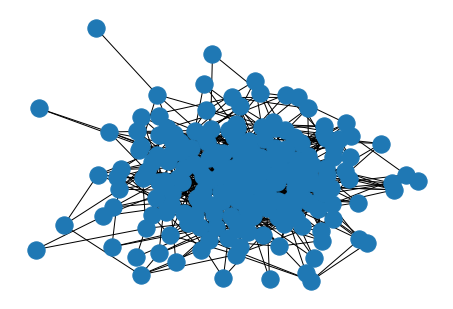

In [ ]:
nx.draw(generated_graphs[5])
plt.show()

## GRAN Test

In [7]:
import os
import sys
import torch
import logging
import traceback
import numpy as np
from pprint import pprint

from baselineModels.GRAN.train import *
from baselineModels.GRAN.utils.logger import setup_logging
from baselineModels.GRAN.utils.arg_helper import parse_arguments, get_config

torch.set_printoptions(profile='full')

ModuleNotFoundError: No module named 'pyemd'

In [ ]:
config = get_config("baselineModels/GRAN/config/gran_grid.yaml")
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
config.use_gpu = config.use_gpu and torch.cuda.is_available()

# log info
log_file = os.path.join(config.save_dir, "log_exp_{}.txt".format(config.run_id))
logger = setup_logging(args.log_level, log_file)
logger.info("Writing log file to {}".format(log_file))
logger.info("Exp instance id = {}".format(config.run_id))
logger.info("Exp comment = {}".format(args.comment))
logger.info("Config =")
print(">" * 80)
pprint(config)
print("<" * 80)

# Run the experiment
try:
    runner = eval(config.runner)(config)
    runner.train()
    runner.test()
except:
    logger.error(traceback.format_exc())

sys.exit(0)